In [1]:
import sys
print(sys.executable)
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
from time import time
import pandas as pd
from glob import glob
from KerasOCRTrainer2 import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/bin/python


/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Use

/Users/eduard/.pyenv/versions/3.6.8/envs/keras36/bin/python


# Create df to flow from

In [3]:
# ubuntu
#file_list = glob('/home/eduard/workspace/VitmoOCR/vitmo_video_data/data/*/*.png')
# mac
file_list = glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/data2/*/*.png')
df_lst = []
for file_path in file_list:
    label = file_path.split('/')[-2]
    alt_label = label
    while len(alt_label)<3:
        alt_label = ' '+alt_label
    if alt_label == 'nan':
        alt_label = '   '
        
    l0,l1,l2 = alt_label
    
    df_lst.append({
        'file_path': file_path,
        'single_label':label,
        'multi_label':np.array([l0,l1,l2]),
        'l0':str(l0),
        'l1':str(l1),
        'l2':str(l2),
#         'splitable':f'{l0},{l1},{l2}'
    }
    )
df = pd.DataFrame(df_lst)
print(df.shape)

(147062, 6)


In [4]:
def one_hot(cat):
    categories = [' ','0','1','2','3','4','5','6','7','8','9']
    return (cat==np.array(categories) ).astype(int).tolist()

categories = [' ','0','1','2','3','4','5','6','7','8','9']
for col in ['l0','l1','l2']:
    df[col+'d'] = df[col].apply(one_hot)
df.head()

,file_path,single_label,multi_label,l0,l1,l2,l0d,l1d,l2d
0,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
2,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,/Users/eduard/workspaces/ml_projects/keras/Vit...,135,"[1, 3, 5]",1,3,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"


## Option 2

In [7]:
im_size = 48
ks = 5

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=False,
    validation_split=0.1
)

y_col = ['l0d','l1d','l2d']
class_mode = 'multi_output'

train_generator = train_datagen.flow_from_dataframe(
    df, directory='/', x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="training", classes=categories,
    batch_size=32, seed=42)

valid_generator = train_datagen.flow_from_dataframe(
    df, directory='/', x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="validation", classes=categories,
    batch_size=32, seed=42)

Found 132356 validated image filenames.
Found 14706 validated image filenames.


In [19]:
input_img = Input(shape=(im_size, im_size, 3))
# gs_img = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(input_img)
conv1 = Conv2D(32, (ks, ks), strides=2, padding='same', activation='relu')(input_img)
drop1 = Dropout(0.05)(conv1)
conv2 = Conv2D(32, (ks, ks), strides=2, padding='same', activation='relu')(drop1)
drop2 = Dropout(0.05)(conv2)
# conv3 = Conv2D(32, (ks, ks), strides=2, padding='same', activation='relu')(drop2)
flat1  = Flatten()(drop2)
# dense1 = Dense(512,activation='relu')(flat1)
num1 = Dense(11,activation='softmax',name='num1')(flat1)
num2 = Dense(11,activation='softmax',name='num2')(flat1)
num3 = Dense(11,activation='softmax',name='num3')(flat1)

# output = keras.layers.concatenate([num1,num2,num3])
# output = [num1,num2,num3]?
model = Model(inputs = input_img, outputs=[num1,num2,num3])
model

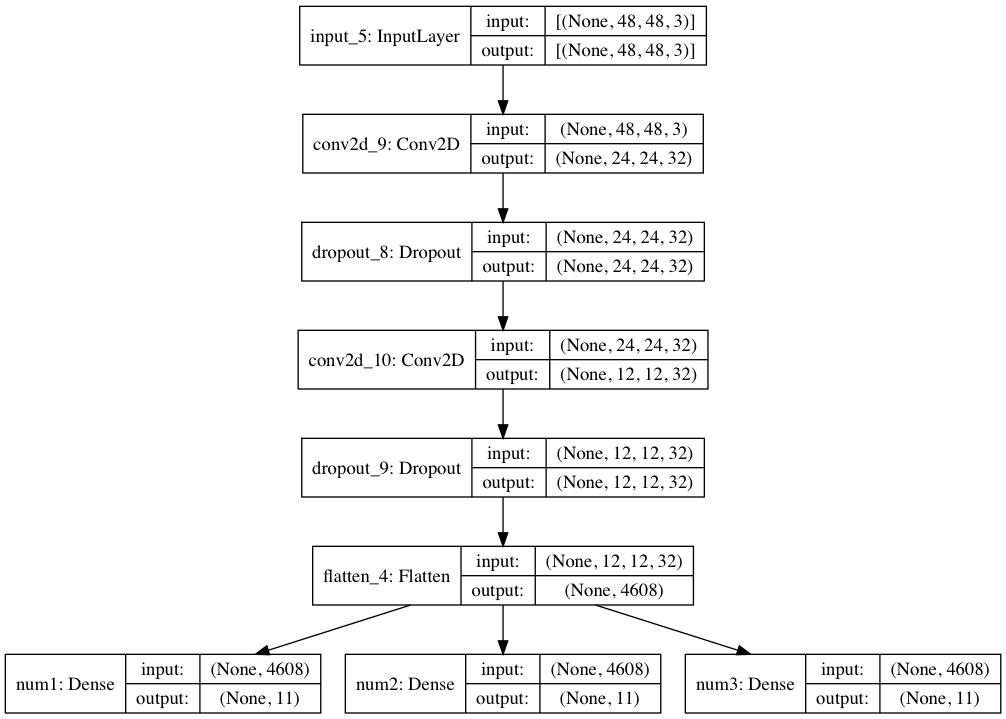

In [20]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

In [21]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 24, 24, 32)   2432        input_5[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 24, 24, 32)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 12, 12, 32)   25632       dropout_8[0][0]                  
____________________________________________________________________________________________

In [22]:
model.compile(optimizers.Adam(lr=0.001),loss=["categorical_crossentropy"]*3,metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10
4136/4136 [==============================] - 421s 102ms/step - loss: 2.2330 - num1_loss: 0.1619 - num2_loss: 0.9609 - num3_loss: 1.1101 - num1_acc: 0.9409 - num2_acc: 0.6924 - num3_acc: 0.6458 - val_loss: 1.4638 - val_num1_loss: 0.0596 - val_num2_loss: 0.7784 - val_num3_loss: 0.6258 - val_num1_acc: 0.9819 - val_num2_acc: 0.7567 - val_num3_acc: 0.8167
Epoch 2/10
 840/4136 [=====>........................] - ETA: 5:43 - loss: 1.0708 - num1_loss: 0.0606 - num2_loss: 0.4557 - num3_loss: 0.5545 - num1_acc: 0.9810 - num2_acc: 0.8645 - num3_acc: 0.8363